# Module 3 Project - Whisky Sommelier
# Hypothesis Testing
By: **Maura Cerow**, **Rajeev Panwar** and **Bryan Santos**

This project aims to build the first module of a comprehensive whisky recommendation engine, an **automated whisky sommelier**. We would like this to act as a go-to "middle-man" between distributors, bars and consumers.

This notebook in particular handles all the hypothesis testing. The point of the tests is to ensure that the independent variables we have chosen are significant as predictors of our dependent variable.

## Dataset

After data cleaning, we have retained a total of 2,622 observations in our dataset. The following are our target and feature variables. We still plan to add some new predictors based on the resulting EDA and feature interactions. 

**Target**  
- Whisky's country of origin: 
    - Scotland
    - Japan
    - USA
    - Canada
    - Ireland

**Features**
- Type (whether it is Single Malt, Blended, Rye, etc.)
- Price (ranging from 1 to 5 with 5 being the most expensive)
- Expert Score (critic score)
- User Rating (distiller.com user reviews)
- ABV (Alcohol By Volume)
- Description
- Style (ingredients)
- Maturing/Cask (whether matured in Oak, Sherry, etc.)
- Flavor Profiles (each having intensity scores ranging from 0 to 100):
    - *Smoky*
    - *Peaty*
    - *Spicy*
    - *Herbal*
    - *Oily*
    - *Full-Bodied*
    - *Rich*
    - *Sweet*
    - *Briny*
    - *Salty*
    - *Vanilla*
    - *Tart*
    - *Fruity*
    - *Floral*

## Package Imports and Data Load

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import scipy.stats as stats
import scipy

sns.set()
%matplotlib inline

### Suppress notebook warnings ###
import warnings
warnings.filterwarnings('ignore')

### Pandas settings to avoid exponential form and display all columns ###
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("whisky_df_clean.csv", sep=',')

In [3]:
df.head(5)

,name,type,price,expert_score,user_rating,description,abv,style,cask,review,smoky,peaty,spicy,herbal,oily,full-bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral,country
0,Hibiki 21 Year,Blended,5,99,4.520,Hibiki is the blended whisky brand produced by...,43.000,Comprised of both single malt(s) and single gr...,"ex-bourbon American oak, ex-sherry European oa...","""Tasting this whisky was one of those moments ...",30,30,50,30,20,80,80,85,0,15,20,25,85,50,4
1,Highland Park 18 Year,Peated Single Malt,4,99,4.490,Shudder to think that Highland Park 18 has onl...,43.000,100% malted barley from a single distillery. D...,ex-sherry,"""The sweet smoke is the underlying feature in ...",40,40,40,20,40,70,80,70,20,40,50,50,70,20,0
2,George T. Stagg Bourbon (Fall 2019),Bourbon,4,98,4.590,George T. Stagg Bourbon (Fall 2019) is an uncu...,58.450,Produced anywhere in USA; Mash bill of at leas...,"new, charred American oak","""Lots of oak shows up on the nose along with c...",40,40,65,50,20,60,60,45,0,0,60,60,45,0,1
3,Bowmore Mizunara Cask Finish,Peated Single Malt,5,98,4.190,This is the first-ever official Islay single m...,53.900,100% malted barley from a single distillery. D...,"ex-bourbon, ex-sherry, new Mizunara oak","""Though the time in Mizunara oak was relativel...",30,30,40,30,10,75,75,60,15,20,30,20,50,5,0
4,The Macallan M,Single Malt,5,98,4.190,A 6-litre Lalique decanter of this single malt...,47.700,Distilled in pot stills from 100% malted barle...,sherry oak casks,"""The aroma is that pleasing bouquet that comes...",50,50,60,0,15,90,100,50,0,0,20,20,80,10,0


## Functions for Reuse

We create a function for running ANOVA test and post-hoc analysis with Tukey because they will be run multiple times. 

In [159]:
def anova_tukey(feature):
    '''
    This function automatically runs Analysis of Variance (ANOVA) and the
    corresponding post-hoc analysis using Tukey. This will be run against
    each country of origin (aka the dependent variable)
    
    Parameter: 
        Feature: target column as string 
          
    Returns: 
        This prints out the ANOVA result plus the corresponding post-hoc
        analysis results using Tukey-MC.
    
    '''
    anova_countries = ols(feature + '~countries_cat', data=df).fit()
    anova_countries
    anova_table = sm.stats.anova_lm(anova_countries, type=2)
    print(anova_table)
    print()
    mc = MultiComparison(df[feature], df['countries_cat'])
    mc_results = mc.tukeyhsd()
    print(mc_results.summary())

## Distribution of Observations

To further prove that there is class imbalance, we conduct an hypothesis testing using Chi-Square Goodness of Fit. We use an alpha value of .05.

**H0:** Even distribution of whisky observations across all countries of origin

**H1:** Uneven distribution of whisky observations across all countries of origin

In [127]:
### Encoded country names for better visual representation ###
countries = { 0: 'Scotch',
              1: 'American',
              2: 'Canadian',
              3: 'Irish',
              4: 'Japanese'
           }
df['countries_cat'] = df.country.map(countries)

In [132]:
### Count whisky observations per country of origin ###
country_df = df.groupby('countries_cat', as_index=False).agg({'price': ['count']})
country_df.columns = country_df.columns.droplevel(0)
country_df.columns = ['country', 'count']
country_df

,country,count
0,American,1192
1,Canadian,175
2,Irish,152
3,Japanese,111
4,Scotch,1032


In [133]:
### Compute for the expected value if there is even distribution ###
expected = country_df['count'].sum() / country_df.shape[0]
expected_array = np.full((country_df.shape[0],), expected)

In [134]:
### Run Chi-Square goodness of fit test ###
scipy.stats.chisquare(country_df['count'], f_exp=expected_array)

Power_divergenceResult(statistic=2131.2719759579263, pvalue=0.0)

**Observations**

Because the resulting p-value is less than the alpha value, we **reject the null** hypothesis that there is even distribution of whisky datapoints across each country of origin in our dataset. This further proves that we will need to address class imbalance later on.

## Basic Features

To determine features most suitable for classification, we conducted hypothesis testing. We tested several "out-of-the-box" features. 

We conduct ANOVA for each feature to determine if there is a significant difference between the country of origin based on each of the feature selected. Then we run a Tukey Multi-Comparison to further deep-dive and verify which pair of the countries of origin have signifcant differences. We use an alpha value of .05.

### Price

**H0:** The prices of whisky bottles from all countries of origin are the same

**H1:** The prices of whisky bottles from all countries of origin are NOT the same

<function matplotlib.pyplot.show(*args, **kw)>

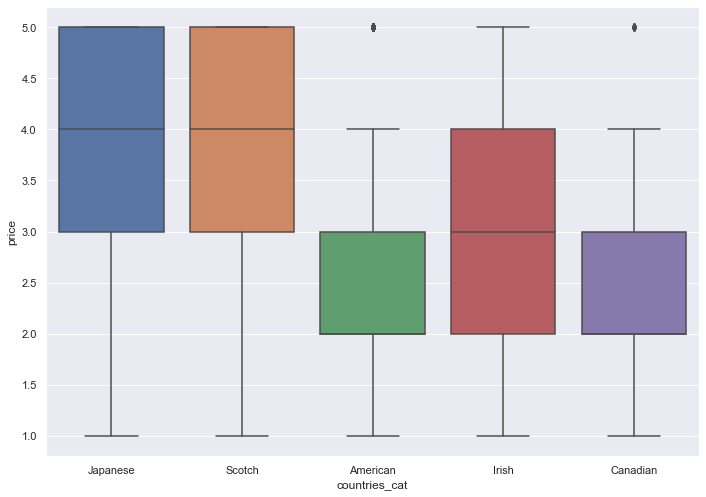

In [69]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(y=df['price'], x=df['countries_cat'], width=0.8)

plt.show

In [160]:
anova_tukey("price")

                    df   sum_sq  mean_sq       F  PR(>F)
countries_cat    4.000  595.422  148.855 133.004   0.000
Residual      2657.000 2973.669    1.119     nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
American Canadian  -0.2343 0.0491 -0.4681 -0.0006   True
American    Irish   0.1472  0.488 -0.1015  0.3959  False
American Japanese   1.2413  0.001  0.9547  1.5279   True
American   Scotch   0.8885  0.001  0.7658  1.0113   True
Canadian    Irish   0.3815 0.0102  0.0613  0.7017   True
Canadian Japanese   1.4756  0.001  1.1252   1.826   True
Canadian   Scotch   1.1229  0.001  0.8868   1.359   True
   Irish Japanese   1.0941  0.001  0.7336  1.4547   True
   Irish   Scotch   0.7414  0.001  0.4905  0.9923   True
Japanese   Scotch  -0.3527 0.0076 -0.6412 -0.0643   True
--------------------------------------------------------


Because the p-value is less than alpha, we **reject the null** hypothesis that the prices of whisky bottles coming from all countries are the same. The ANOVA result is showing that there is indeed a significant difference in the prices from different countries of origin. This warrants a post-hoc analysis in order to determine between which countries has these significant differences.

Out of 10 pairwise comparisons, 9 of them have rejected the null hypothesis that prices are the same. There are significant differences in terms of price. This can mean that price may be a significant feature as predictor of our dependent variable.

### Expert Score

**H0:** The expert scores based on reviews of whisky bottles from all countries of origin are the same

**H1:** The expert scores based on reviews of whisky bottles from all countries of origin are NOT the same

<function matplotlib.pyplot.show(*args, **kw)>

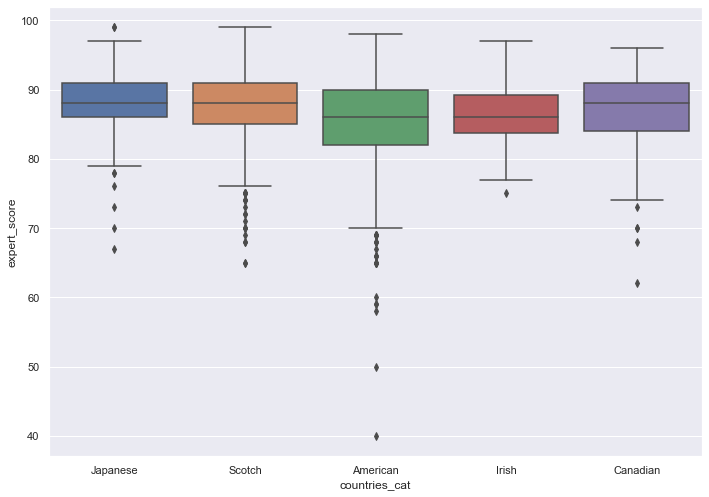

In [75]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(y=df['expert_score'], x=df['countries_cat'], width=0.8)

plt.show

In [161]:
anova_tukey("expert_score")

                    df    sum_sq  mean_sq      F  PR(>F)
countries_cat    4.000  3773.736  943.434 28.260   0.000
Residual      2657.000 88702.172   33.384    nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
American Canadian   1.7763 0.0014  0.4996 3.0531   True
American    Irish     1.32 0.0616 -0.0384 2.6783  False
American Japanese   3.1224  0.001  1.5573 4.6876   True
American   Scotch   2.4451  0.001  1.7745 3.1157   True
Canadian    Irish  -0.4564    0.9  -2.205 1.2923  False
Canadian Japanese   1.3461 0.3069 -0.5676 3.2598  False
Canadian   Scotch   0.6687 0.6019 -0.6206 1.9581  False
   Irish Japanese   1.8025  0.091 -0.1667 3.7716  False
   Irish   Scotch   1.1251  0.165 -0.2451 2.4953  False
Japanese   Scotch  -0.6774 0.7393 -2.2528 0.8981  False
-------------------------------------------------------


Because the p-value is less than alpha, we **reject the null** hypothesis that the prices of whisky bottles coming from all countries are the same. The ANOVA result is showing that there is indeed a significant difference in the prices from different countries of origin. This warrants a post-hoc analysis in order to determine between which countries has these significant differences.

Out of 10 pairwise comparisons, only 3 of them have significant differences in terms of expert scores. Nevertheless, the fact that we have rejected the null hypothesis for 3 pairs may mean that this feature is not completely insignificant.

### User Rating

**H0:** The user ratings of whisky bottles from all countries of origin are the same

**H1:** The user ratings of whisky bottles from all countries of origin are NOT the same

<function matplotlib.pyplot.show(*args, **kw)>

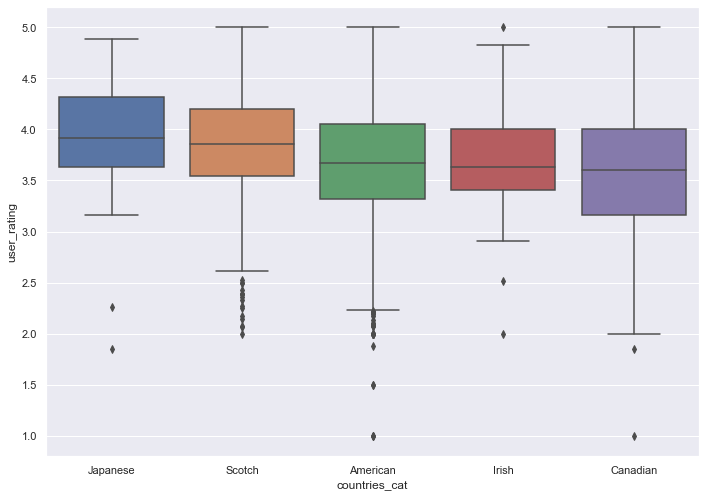

In [81]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(y=df['user_rating'], x=df['countries_cat'], width=0.8)

plt.show

In [162]:
anova_tukey("user_rating")

                    df  sum_sq  mean_sq      F  PR(>F)
countries_cat    4.000  34.192    8.548 28.504   0.000
Residual      2657.000 796.805    0.300    nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
American Canadian   -0.056 0.6889  -0.177  0.065  False
American    Irish   0.0579 0.7088 -0.0709 0.1866  False
American Japanese   0.3071  0.001  0.1587 0.4554   True
American   Scotch   0.2125  0.001  0.1489  0.276   True
Canadian    Irish   0.1139  0.331 -0.0519 0.2796  False
Canadian Japanese    0.363  0.001  0.1817 0.5444   True
Canadian   Scotch   0.2685  0.001  0.1463 0.3907   True
   Irish Japanese   0.2492 0.0025  0.0625 0.4358   True
   Irish   Scotch   0.1546 0.0103  0.0247 0.2845   True
Japanese   Scotch  -0.0946 0.4179 -0.2439 0.0547  False
-------------------------------------------------------


Because the p-value is less than alpha, we **reject the null** hypothesis that the user scores of whisky bottles coming from all countries are the same. The ANOVA result is showing that there is indeed a significant difference in the user scores. This warrants a post-hoc analysis in order to determine between which countries has these significant differences.

Out of 10 pairwise comparisons, 6 of them have significant differences in terms of user ratings. There are significant differences in terms of user ratings. This can mean that user rating may be a significant feature as predictor of our dependent variable.

### Alcohol Content

**H0:** The alcohol content of whisky bottles from all countries of origin are the same

**H1:** The alcohol content of whisky bottles from all countries of origin are NOT the same

<function matplotlib.pyplot.show(*args, **kw)>

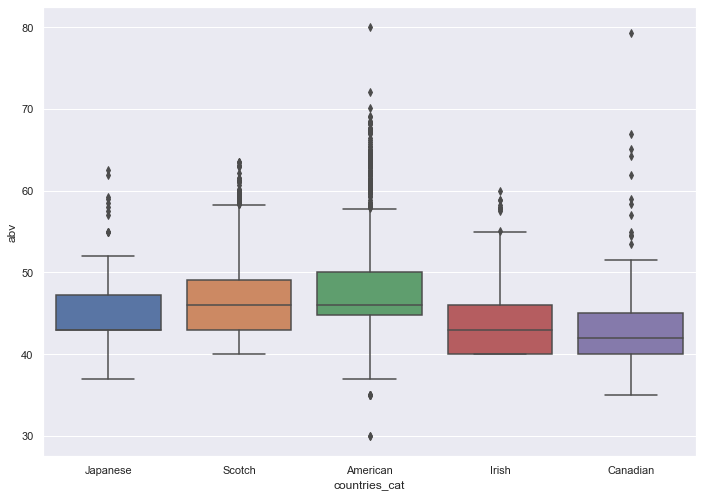

In [90]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.boxplot(y=df['abv'], x=df['countries_cat'], width=0.8)

plt.show

In [163]:
anova_tukey("abv")

                    df     sum_sq  mean_sq      F  PR(>F)
countries_cat    4.000   5239.510 1309.878 34.162   0.000
Residual      2657.000 101876.729   38.343    nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
American Canadian   -4.431  0.001 -5.7993 -3.0627   True
American    Irish  -4.0978  0.001 -5.5535  -2.642   True
American Japanese  -2.6724  0.001 -4.3497 -0.9951   True
American   Scotch  -1.6312  0.001 -2.3499 -0.9125   True
Canadian    Irish   0.3332    0.9 -1.5408  2.2073  False
Canadian Japanese   1.7586 0.1322 -0.2923  3.8095  False
Canadian   Scotch   2.7998  0.001   1.418  4.1816   True
   Irish Japanese   1.4254 0.3489 -0.6849  3.5357  False
   Irish   Scotch   2.4666  0.001  0.9981   3.935   True
Japanese   Scotch   1.0412 0.4461 -0.6472  2.7296  False
--------------------------------------------------------


Because the p-value is less than alpha, we **reject the null** hypothesis that the alcohol content of whisky bottles coming from all countries are the same. The ANOVA result is showing that there is indeed a significant difference in alcohol conent. This warrants a post-hoc analysis in order to determine between which countries has these significant differences.

Out of 10 pairwise comparisons, 6 of them have significant differences in terms of alcohol content. There are significant differences in terms of user ratings. This can mean that user rating may be a significant feature as predictor of our dependent variable.

### Flavor Profiles

Finally, we conduct hypothesis testing on the fourteen (14) different flavor profile intensity levels. We believe that this may be the key feaetures in predicting our dependent variable based on the assumption that there are distinct flavor profiles of whiskies coming from a specific country.

We conduct ANOVA for each flavor profile to determine if there is a significant difference between the countries flavor-wise. Then we run a Tukey Multi-Comparison to further deep-dive and verify which pair of the countries of origin have signifcant differences. We use an alpha value of .05.

**H0:** All whiskies from different countries have the same flavor profiles

**H1:** All whiskies from different countries do NOT have the same flavor profiles

In [175]:
### Create a list of all flavor profiles ###
flavors = ['smoky', 'peaty', 'spicy', 'herbal',
       'oily', 'fullbodied', 'rich', 'sweet', 'briny', 'salty', 'vanilla',
       'tart', 'fruity', 'floral']

In [176]:
df = df.rename(columns={'full-bodied': 'fullbodied'})

In [177]:
df.columns

Index(['name', 'type', 'price', 'expert_score', 'user_rating', 'description',
       'abv', 'style', 'cask', 'review', 'smoky', 'peaty', 'spicy', 'herbal',
       'oily', 'fullbodied', 'rich', 'sweet', 'briny', 'salty', 'vanilla',
       'tart', 'fruity', 'floral', 'country', 'counties_cat', 'countries_cat'],
      dtype='object')

anova_countries = ols('smoky~countries_cat', data=df).fit()
anova_countries

In [178]:
### Run ANOVA and Tukey-MC for each flavor profile ###
for flavor in flavors:
    
    anova_table = sm.stats.anova_lm(anova_countries, type=2)
    print(flavor.upper() + "\n")
    anova_tukey(flavor)
    print()

SMOKY

                    df      sum_sq   mean_sq      F  PR(>F)
countries_cat    4.000   45260.301 11315.075 26.470   0.000
Residual      2657.000 1135774.954   427.465    nan     nan

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower    upper  reject
---------------------------------------------------------
American Canadian  10.8377  0.001   6.2691 15.4062   True
American    Irish  -1.7605 0.8442  -6.6211  3.1002  False
American Japanese   4.6443 0.1572  -0.9562 10.2449  False
American   Scotch   7.5628  0.001   5.1632  9.9625   True
Canadian    Irish -12.5981  0.001 -18.8554 -6.3408   True
Canadian Japanese  -6.1933  0.098 -13.0412  0.6546  False
Canadian   Scotch  -3.2748 0.2977  -7.8885  1.3389  False
   Irish Japanese   6.4048 0.0951  -0.6413 13.4509  False
   Irish   Scotch   9.3233  0.001   4.4202 14.2264   True
Japanese   Scotch   2.9185 0.6034  -2.7189  8.5558  False
---------------------------------------------------------


  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
American Canadian     -0.4    0.9 -3.5989   2.799  False
American    Irish   0.9254    0.9  -2.478  4.3288  False
American Japanese   10.503  0.001  6.5816 14.4245   True
American   Scotch  11.8329  0.001 10.1527 13.5131   True
Canadian    Irish   1.3254    0.9  -3.056  5.7067  False
Canadian Japanese   10.903  0.001  6.1081 15.6978   True
Canadian   Scotch  12.2329  0.001  9.0024 15.4634   True
   Irish Japanese   9.5776  0.001  4.6439 14.5112   True
   Irish   Scotch  10.9075  0.001  7.4744 14.3406   True
Japanese   Scotch   1.3299 0.8834 -2.6174  5.2772  False
--------------------------------------------------------

SALTY

                    df     sum_sq   mean_sq       F  PR(>F)
countries_cat    4.000  98665.149 24666.287 118.820   0.000
Residual      2657.000 551575.152   207.593     nan     nan

  Multiple Co

**Observations**

We note that out of the resulting 14 ANOVA tables, none of them has a p-value that is greater than the alpha. Thus, we **reject all null** hypothesis that each flavor profile are the same across the whiskies from different countries.

Furthermore, all of the Tukey comparisons resulted to at least one True value for rejecting the null hypothesis. This means that each of the flavor profile may be significant in predicting our dependent variable, most especially when all of these flavor scores are combined together.